# Setup
Follow [these instructions](https://cloud.google.com/datastore/docs/reference/libraries) to 
1. create a service account
2. create a key for the service account (& download the key)
3. set the local env variable pointing to the key file

# Download require packages

In [15]:
! pip install --upgrade google-cloud-storage
! pip install --upgrade google-cloud-datastore

## Load the local dataset

In [7]:
import pandas as pd
from PIL import Image
from pathlib import Path

DATASET_PATH = Path("/home/andretelfer/berlin2022/datasets/CUv3/")

manual_scores = pd.read_excel(DATASET_PATH / 'mgs_scores.xlsx')
manual_scores = manual_scores.dropna(subset=["Mean_Scorer4"]) # Drop rows without a score
manual_scores.head(3)

,ID,Path,Filename,Useless,Score-Count,Eyes_Scorer4,Nose_Scorer4,Cheeks_Scorer4,Ears_Scorer4,Whiskers_Scorer4,Sum_Scorer4,Mean_Scorer4,Comment_Scorer4
0,1.0,/usr/src/app/media/images/Basler_acA1920-40um_...,12296.png,0.0,1.0,1.0,0.0,1.0,0.0,1.0,3.0,0.6,NaN
1,2.0,/usr/src/app/media/images/Basler_acA1920-40um_...,03307.png,0.0,1.0,1.0,0.0,1.0,1.0,2.0,5.0,1.0,NaN
2,3.0,/usr/src/app/media/images/Basler_acA1920-40um_...,07266.png,0.0,1.0,1.0,1.0,0.0,1.0,2.0,5.0,1.0,NaN


In [99]:
df = manual_scores.copy()
df['path'] = df.apply(lambda x: Path(*Path(x.Path).parts[-2:]) / x.Filename, axis=1)
df = df.rename(columns={'Eyes_Scorer4': 'eyes', 'Nose_Scorer4': 'nose', 'Cheeks_Scorer4': 'cheeks', 'Ears_Scorer4': 'ears', 'Whiskers_Scorer4': 'whiskers'})
df = df[['path', 'eyes', 'nose', 'cheeks', 'ears', 'whiskers']]
df = df.fillna(0)
for col in ['eyes', 'nose', 'cheeks', 'ears', 'whiskers']:
    df[col] = df[col].astype(int)
    
df

,path,eyes,nose,cheeks,ears,whiskers
0,images/Basler_acA1920-40um__23999063__20220620...,1,0,1,0,1
1,images/Basler_acA1920-40um__23999063__20220613...,1,0,1,1,2
2,images/Basler_acA1920-40um__23999063__20220620...,1,1,0,1,2
3,images/Basler_acA1920-40um__23999063__20220616...,1,1,1,1,2
4,images/Basler_acA1920-40um__23999063__20220613...,1,0,0,1,2
...,...,...,...,...,...,...
195,images/Basler_acA1920-40um__23999063__20220617...,0,0,0,0,0
196,images/Basler_acA1920-40um__23999063__20220617...,1,0,1,1,1
197,images/Basler_acA1920-40um__23999063__20220617...,0,1,0,0,1
198,images/Basler_acA1920-40um__23999063__20220614...,2,2,2,1,2


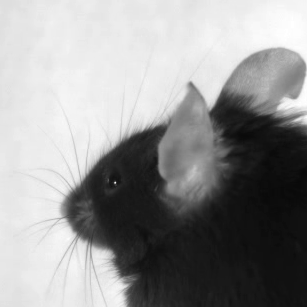

In [63]:
Image.open(DATASET_PATH / df.path[0])

# Delete and recreate the bucket

In [3]:
# Imports the Google Cloud client library
from google.cloud import storage

# Instantiates a client
storage_client = storage.Client()

# The name for the new bucket
bucket_name = "mgs-webapp"

In [127]:
# Creates the new bucket
try:
    bucket = storage_client.get_bucket(bucket_name)
    bucket.delete(force=True)
except:
    pass

bucket = storage_client.create_bucket(bucket_name)
print(f"Bucket {bucket.name} created.")

Bucket mgs-webapp created.


### Make the bucket public

In [67]:
members = ["allUsers"]
bucket = storage_client.bucket(bucket_name)
policy = bucket.get_iam_policy(requested_policy_version=3)
policy.bindings.append(
    {"role": "roles/storage.objectViewer", "members": members}
)
bucket.set_iam_policy(policy)

## Empty the datastore

In [2]:
# Imports the Google Cloud client library
from google.cloud import datastore

# Instantiates a client
datastore_client = datastore.Client()

In [131]:
query = datastore.Query(datastore_client)

for entity in list(query.fetch())[:3]:
    print(entity)

In [66]:
for entity in query.fetch():
    datastore_client.delete(entity.key)

In [37]:
query = datastore.Query(datastore_client)

for entity in query.fetch():
    print(entity)

<Entity('Example', 'images/Basler_acA1920-40um__23999063__20220613_110536538_MGSframes/00548.png') {'scorer': 'TUBerlin/KatharinaHohlbaum', 'path': 'images/Basler_acA1920-40um__23999063__20220613_110536538_MGSframes/00548.png', 'nose': 1, 'url': 'https://storage.googleapis.com/mgs-webapp/images/Basler_acA1920-40um__23999063__20220613_110536538_MGSframes/00548.png', 'ears': 1, 'whiskers': 2, 'eyes': 0, 'cheeks': 0}>
<Entity('Example', 'images/Basler_acA1920-40um__23999063__20220613_110536538_MGSframes/09395.png') {'path': 'images/Basler_acA1920-40um__23999063__20220613_110536538_MGSframes/09395.png', 'eyes': 0, 'nose': 1, 'ears': 1, 'whiskers': 0, 'scorer': 'TUBerlin/KatharinaHohlbaum', 'cheeks': 0, 'url': 'https://storage.googleapis.com/mgs-webapp/images/Basler_acA1920-40um__23999063__20220613_110536538_MGSframes/09395.png'}>
<Entity('Example', 'images/Basler_acA1920-40um__23999063__20220613_111914471_MGSframes/12507.png') {'eyes': 1, 'path': 'images/Basler_acA1920-40um__23999063__2022

# Add items

In [134]:
from tqdm import tqdm

scorer = "TUBerlin/KatharinaHohlbaum"

for idx, row in tqdm(df.iterrows()):
    item = row.to_dict()
    item['scorer'] = scorer
    item['path'] = str(item['path'])
    
    # Upload to google cloud storage
    blob = bucket.blob(str(row.path))
    blob.upload_from_filename(str(DATASET_PATH / row.path))
    blob.make_public()
    item['url'] = blob.public_url
    
    # Upload to google datastore
    example_key = datastore_client.key("Example", str(row.path))
    example = datastore.Entity(key=example_key)
    example.update(item)
    
    datastore_client.put(example)

200it [03:10,  1.05it/s]


## Check upload successful

In [140]:
example['url']

'https://storage.googleapis.com/mgs-webapp/images/Basler_acA1920-40um__23999063__20220613_122132533_MGSframes/20311.png'

In [138]:
blob.public_url

'https://storage.googleapis.com/mgs-webapp/images/Basler_acA1920-40um__23999063__20220613_122132533_MGSframes/20311.png'

In [12]:
query = datastore_client.query(kind="Example")
query_iter = query.fetch()
for entity in list(query_iter)[:5]:
    print(entity)

<Entity('Example', 'images/Basler_acA1920-40um__23999063__20220613_110536538_MGSframes/00548.png') {'nose': 1, 'eyes': 0, 'ears': 1, 'url': 'https://storage.googleapis.com/mgs-webapp/images/Basler_acA1920-40um__23999063__20220613_110536538_MGSframes/00548.png', 'path': 'images/Basler_acA1920-40um__23999063__20220613_110536538_MGSframes/00548.png', 'scorer': 'TUBerlin/KatharinaHohlbaum', 'cheeks': 0, 'whiskers': 2}>
<Entity('Example', 'images/Basler_acA1920-40um__23999063__20220613_110536538_MGSframes/09395.png') {'cheeks': 0, 'whiskers': 0, 'eyes': 0, 'ears': 1, 'url': 'https://storage.googleapis.com/mgs-webapp/images/Basler_acA1920-40um__23999063__20220613_110536538_MGSframes/09395.png', 'scorer': 'TUBerlin/KatharinaHohlbaum', 'nose': 1, 'path': 'images/Basler_acA1920-40um__23999063__20220613_110536538_MGSframes/09395.png'}>
<Entity('Example', 'images/Basler_acA1920-40um__23999063__20220613_111914471_MGSframes/12507.png') {'nose': 1, 'path': 'images/Basler_acA1920-40um__23999063__2022

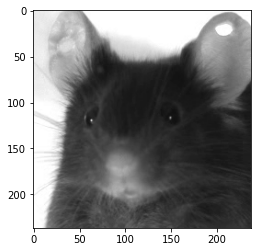

In [17]:
import matplotlib.pyplot as plt
from skimage.io import imread

image = imread(entity['url'])
plt.imshow(image)

In [57]:
session_key = datastore_client.key("Session")
session = datastore.Entity(key=session_key)
session['answers'] = 1
datastore_client.put(session)

In [59]:
key = datastore_client.key("Session", session.id)
datastore_client.get(key=key)

<Entity('Session', 5716561121771520) {'answers': 1}>

In [68]:
query = datastore_client.query(kind="Session")
# query = query.add_filter("id", "=", session.id)
for item in query.fetch():
    datastore_client.delete(item)
    print(item)

<Entity('Session', 5633378543992832) {'questions': []}>
<Entity('Session', 5637476211228672) {'questions': [<Entity {'id': 19}>]}>
<Entity('Session', 5640825748848640) {'questions': []}>
<Entity('Session', 5643280054222848) {'questions': []}>
<Entity('Session', 5704134103662592) {'questions': [<Entity {'id': 75}>]}>


In [69]:
query = datastore_client.query(kind="Question")
for item in query.fetch():
    print(item)

<Entity('Question', 1) {'url': 'https://storage.googleapis.com/mgs-webapp/1.png', 'eyes': 1, 'nose': 0, 'path': 'resized-images/Basler_acA1920-40um__23999063__20220620_110547917_MGSframes/12296.png', 'cheeks': 1, 'ears': 0, 'origin': 'Data from Carleton University, Labels from TU Berlin', 'whiskers': 1}>
<Entity('Question', 2) {'cheeks': 1, 'eyes': 1, 'ears': 1, 'path': 'resized-images/Basler_acA1920-40um__23999063__20220613_142819214_MGSframes/03307.png', 'url': 'https://storage.googleapis.com/mgs-webapp/2.png', 'origin': 'Data from Carleton University, Labels from TU Berlin', 'nose': 0, 'whiskers': 2}>
<Entity('Question', 3) {'origin': 'Data from Carleton University, Labels from TU Berlin', 'eyes': 1, 'cheeks': 0, 'ears': 1, 'url': 'https://storage.googleapis.com/mgs-webapp/3.png', 'whiskers': 2, 'nose': 1, 'path': 'resized-images/Basler_acA1920-40um__23999063__20220620_110547917_MGSframes/07266.png'}>
<Entity('Question', 4) {'eyes': 1, 'nose': 1, 'url': 'https://storage.googleapis.c